### addition_average.pyを元にデータの加工
主に
- 加算平均の処理
- 描画
- CSDの描画  

を行う

In [1]:
import pandas as pd
import numpy as np
import json
import os, sys
import scipy.io
from scipy import signal
import matplotlib.pyplot as plt
import statistics
import math
import gc
import sys
import os
import warnings
from pathlib import Path
import re
import json
from scipy import fftpack

In [2]:
#numpyをjsonで出力できるように修正
class MyEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        elif isinstance(obj, np.floating):
            return float(obj)
        elif isinstance(obj, np.ndarray):
            return obj.tolist()
        else:
            return super(MyEncoder, self).default(obj)

In [3]:
#bandpass_filterの設定
def bandpass(x, samplerate, fp, fs, gpass, gstop):
    fn = samplerate / 2                           #ナイキスト周波数
    wp = fp / fn                                  #ナイキスト周波数で通過域端周波数を正規化
    ws = fs / fn                                  #ナイキスト周波数で阻止域端周波数を正規化
    N, Wn = signal.buttord(wp, ws, gpass, gstop)  #オーダーとバターワースの正規化周波数を計算
    b, a = signal.butter(N, Wn, "band")           #フィルタ伝達関数の分子と分母を計算
    y = signal.filtfilt(b, a, x)                  #信号に対してフィルタをかける
    return y  
#バターワースフィルタ（ローパス）
def lowpass(x, samplerate, fp, fs, gpass, gstop):
    fn = samplerate / 2                           #ナイキスト周波数
    wp = fp / fn                                  #ナイキスト周波数で通過域端周波数を正規化
    ws = fs / fn                                  #ナイキスト周波数で阻止域端周波数を正規化
    N, Wn = signal.buttord(wp, ws, gpass, gstop)  #オーダーとバターワースの正規化周波数を計算
    b, a = signal.butter(N, Wn, "low")            #フィルタ伝達関数の分子と分母を計算
    y = signal.filtfilt(b, a, x)                  #信号に対してフィルタをかける
    return y                                      #フィルタ後の信号を返す
#バターワースフィルタ（バンドストップ）
def bandstop(x, samplerate, fp, fs, gpass, gstop):
    fn = samplerate / 2                           #ナイキスト周波数
    wp = fp / fn                                  #ナイキスト周波数で通過域端周波数を正規化
    ws = fs / fn                                  #ナイキスト周波数で阻止域端周波数を正規化
    N, Wn = signal.buttord(wp, ws, gpass, gstop)  #オーダーとバターワースの正規化周波数を計算
    b, a = signal.butter(N, Wn, "bandstop")       #フィルタ伝達関数の分子と分母を計算
    y = signal.filtfilt(b, a, x)                  #信号に対してフィルタをかける
    return y      
def notchpass(x,threshold,samplerate) -> np.ndarray:
    """
    フーリエ変換を使用したノッチフィルタ

    :param x: 波形
    :param threshold: カットする周波数閾値，低周波/高周波の順に並んだものを受け取る
    """
    if threshold[0] > threshold[1]:
        raise ValueError()
    spectral = fftpack.fft(x, axis=0)
    index =  len(x)/samplerate* np.array(threshold)
    index = np.array(index,dtype="int64")
    spectral[index[0]:index[1]] = 0
    spectral[-index[1]:-index[0]] = 0
    return fftpack.ifft(spectral, axis=0).real

def plot_event(fig, axes, xlim):
    ax = fig.add_subplot(111, zorder=-1)
    ax.set_xlim(xlim[0], xlim[1])
    ax.spines.top.set_visible(False)
    ax.spines.right.set_visible(False)
    ax.spines.left.set_visible(False)
    ax.spines.bottom.set_position(("outward", 10))
    ax.get_shared_x_axes().join(ax, axes[0])
    ax.tick_params(left=False, labelleft=False, right=False)
    ax.set_ylim([0, 1])
    ax.plot([0, 0], [0, 1], color="k", alpha=0.3)
    return
def format_axis(ax):
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['right'].set_visible(False)
    # remove ticks
    ax.tick_params(
        axis='y',          # changes apply to the y-axis
        which='both',      # both major and minor ticks are affected
        left=False,        # ticks along the left edge are off
        right=False,       # ticks along the right edge are off
        labelleft=False)   # labels along the left edge are off
    ax.tick_params(
        axis='x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom=False,      # ticks along the bottom edge are off
        top=False,         # ticks along the top edge are off
        labelbottom=False) # labels along the bottom edge are off
    return

In [4]:
def plot_channels(line,axes,channelmap,ylim):
    for ch_count,channel in enumerate(channelmap,1):
        wave=np.array(line[channel-1])
        i = ch_count-1
        xlim=[-50,350]
        # Set limits and labels
        axes[i].set_facecolor("#ffffff00")
        axes[i].set_xlim(xlim[0],xlim[1])
        axes[i].set_ylim(ylim[0],ylim[1])
        axes[i].set_ylabel(ch_count * 50, rotation=0, ha="right", va="center")
        # Plot base line
        axes[i].plot(xlim, [0, 0], color="k", alpha=0.3, linestyle="--")
        # Plot waveform
        time=range(xlim[0],xlim[1])
        axes[i].plot(time, wave, color="k", clip_on=False,)
        # Format spines and ticks
        if ch_count == len(channelmap):
            axes[i].spines['top'].set_visible(False)
            axes[i].spines['left'].set_visible(False)
            axes[i].spines['bottom'].set_visible(False)
            axes[i].spines['right'].set_position(("outward", 10))
            axes[i].tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
            axes[i].yaxis.tick_right()
            axes[i].set_yticks([ylim[0], 0, ylim[1]])
            axes[i].set_yticklabels([ylim[0], "0 μV", ylim[1]])
        else:
            format_axis(axes[i])
    return

In [5]:
# 各波形から最大の振幅を取り出し、それを統計量として各加算回数による低下を描画
dir_path = Path("E:/experiment/20220221_LFP_ABR/mat")
plx_filelist= list(dir_path.glob("*.mat"))
plx_filelist

[WindowsPath('E:/experiment/20220221_LFP_ABR/mat/click_30.mat'),
 WindowsPath('E:/experiment/20220221_LFP_ABR/mat/click_40.mat'),
 WindowsPath('E:/experiment/20220221_LFP_ABR/mat/click_50.mat'),
 WindowsPath('E:/experiment/20220221_LFP_ABR/mat/click_60.mat'),
 WindowsPath('E:/experiment/20220221_LFP_ABR/mat/click_70.mat'),
 WindowsPath('E:/experiment/20220221_LFP_ABR/mat/click_80.mat'),
 WindowsPath('E:/experiment/20220221_LFP_ABR/mat/us_burst_0.79_window_0.mat'),
 WindowsPath('E:/experiment/20220221_LFP_ABR/mat/us_burst_0.79_window_20.mat'),
 WindowsPath('E:/experiment/20220221_LFP_ABR/mat/us_burst_1.58_window_0.mat'),
 WindowsPath('E:/experiment/20220221_LFP_ABR/mat/us_burst_1.58_window_20.mat'),
 WindowsPath('E:/experiment/20220221_LFP_ABR/mat/us_burst_2.37_window_0.mat'),
 WindowsPath('E:/experiment/20220221_LFP_ABR/mat/us_burst_2.37_window_20.mat'),
 WindowsPath('E:/experiment/20220221_LFP_ABR/mat/us_cont_0.79_window_0ms.mat'),
 WindowsPath('E:/experiment/20220221_LFP_ABR/mat/us_c

In [6]:
def get_timestamp_from_law_ch(single_channel_data,Th,isi,samplerate):
    timestamp=[]
    i=0
    while i<len(single_channel_data):
        if single_channel_data[i]>=Th:
            timestamp.append(i)
            i+=int(isi*samplerate)
        i+=1
    return timestamp

In [7]:
def process_lfp(plx_filepath,offset,onset):
    #取得したpathを元にLFP波形を取得・加算平均を行う
    mat_data=scipy.io.loadmat(plx_filepath)
    #timestampの取得
    samplerate=40000
    event_ch_name="EVT01"
    if event_ch_name in mat_data:
        trigger_wave = mat_data[event_ch_name]
        trigger_wave = list(trigger_wave[j][0] for j in range(len(trigger_wave)))
        #sオーダーで刺激印加時間があるためindex表記に直す
        timestamp_fp = list(round(trigger_wave[i]-float(mat_data["FP01_ts"][0]),3)*1000 for i in range(len(trigger_wave)))
        timestamp_fp = list(map(int,timestamp_fp))
    else:
        trigger_wave= mat_data[f"SPKC{str(20).zfill(2)}"]
        trigger_wave = list(trigger_wave[j][0] for j in range(len(trigger_wave)))
        timestamp=get_timestamp_from_law_ch(trigger_wave,0.05,0.3,samplerate)
        timestamp_time=(np.array(timestamp)+(mat_data["FP01_ts"][0]-mat_data["SPKC20_ts"][0])*samplerate)/40
        timestamp_fp=list(map(round,timestamp_time))
    datas=[]
    for i in range(1, 17):
        fp_name = f"FP{str(i).zfill(2)}"
        each_channel_wave = mat_data[fp_name]
        each_channel_wave = list(
            each_channel_wave[j][0] for j in range(len(each_channel_wave)))
        index = 0
        each_ch_wave=np.zeros(onset+offset)
        for timepoint in timestamp_fp:
            each_wave = np.array(
                each_channel_wave[timepoint-offset:timepoint+onset])
            each_ch_wave+=each_wave
            index+=1
        #加算回数で割ってμVに直す
        each_ch_wave/=index
        each_ch_wave*=1000
        datas.append(each_ch_wave)
    return datas


In [8]:
def plot_lfp(lfp_data,channelmap,ylim,param):
    fig, axes = plt.subplots(nrows=len(channelmap), sharex=True, figsize=[9,6])
    title=f"LFP {param}"
    fig.patch.set_facecolor('white')
    fig.suptitle(title)
    fig.supxlabel("Time from Stimulation (ms)")
    fig.supylabel("Depth from Bran Surface (µm)")
    xlim=[-50,350]
    plot_event(fig, axes, xlim)
    plot_channels(lfp_data,axes,channelmap,ylim)
    if not(os.path.exists("./wave_plot")):
        os.mkdir("./wave_plot")
    fig.savefig(f'./wave_plot/lfp_{param}.png')
    fig.clear()
    plt.close(fig)
    del axes
    del fig
    gc.collect()

In [9]:
def reshape_lfps(lfp_data,channelmap):
    all_waveform=[]
    for channel in channelmap:
        wave=np.array(lfp_data[channel-1]) 
        if len(all_waveform)==0:
            all_waveform=np.array([wave])
        else:
            all_waveform=np.vstack([all_waveform,wave])
    return all_waveform

In [10]:
from scipy import ndimage,interpolate
def source(wave, d: float=0.05):
    return -0.3 * np.gradient(np.gradient(wave, axis=1), axis=1) / (d**2)
def gradient_double(wave):
    return np.gradient(np.gradient(wave, axis=0), axis=0)
def blur(reshape_data,size,axis):
    return ndimage.uniform_filter1d(reshape_data,size,axis)
def spline(reshape_data,size,axis: int=-1):
    x = np.arange(reshape_data.shape[axis])
    function = interpolate.interp1d(x, reshape_data, axis=axis)
    u = np.linspace(0, x[-1], (x.size - 1) * (size + 1) + 1)
    return function(u)

In [11]:
def diff_by_block(base,compare,block_size):
    if len(base)!=len(compare):
        print("base and compare must be same langth")
        return 
    ans = np.zeros(len(base))
    i = 0
    while i*block_size<len(base):
        if (i+1)*block_size < len(base):
            partial=base[i*block_size:(i+1)*block_size]-compare[i*block_size:(i+1)*block_size]
            ans[i*block_size:(i+1)*block_size]+=partial
        else:
            partial=base[i*block_size:len(base)]-compare[i*block_size:(i+1)*len(compare)]
            ans[i*block_size:len(base)]+=partial
        i+=1
    return ans

In [12]:
def plot_csd(lfp_data,channelmap,xlim,vrange,param):
    reshape_datas=reshape_lfps(lfp_data,channelmap)
    reshape_datas=np.flipud(reshape_datas)
    #csd = blur(gradient_double(spline(blur(reshape_data, 3, axis=1), 4, axis=1)), 5, axis=1)
    gradient= gradient_double(reshape_datas)
    inter_length=np.arange(len(gradient))
    csd=spline(gradient,5,0)
    vrange=vrange
    fig=plt.figure()
    xlim=[-50,350]
    fig=plt.figure(facecolor="white")
    ax=fig.add_subplot(111)
    x = np.linspace(xlim[0] , xlim[1], len(csd[0]))
    y = np.linspace( 25, 725, len(csd))
    X,Y=np.meshgrid(x,y[::-1])
    pcm=ax.pcolormesh(X,Y,csd,cmap="jet", shading="auto",vmax=vrange, vmin=-vrange,rasterized=True)
    plt.colorbar(pcm,label="[μV/mm$^2$]")
    ax.invert_yaxis()
    ax.set_yticks(np.arange(50,750,50))
    ax.set_ylabel("depth[μm]")
    ax.set_xlabel("time from stimulation[ms]")
    if not(os.path.exists("./csd_fig")):
        os.mkdir("./csd_fig")
    title=f"csd_{param}"
    plt.title(title)
    plt.savefig(f'./csd_fig/{title}.png')
    plt.clf()
    plt.close()
    gc.collect()

In [13]:
def read_tdtcsv(filename):
    df = pd.read_csv(filename)
    row = df.shape[0]
    column = df.shape[1]
    data_head = df.columns.get_loc("1")
    waveforms = {}
    dB_name = df.columns[df.columns.str.contains("\\(dB\\)")].values[0]
 
    if(row == len(set([i + str(j) for i,j in zip(df["Sub. ID"],df[dB_name])]))):
        datanames = [ str(i) + "dB" for i in df[dB_name]]
    else:
        datanames = [i + " " + str(j) + "dB-" + str(k) for i,j,k in zip(df["Sub. ID"],df[dB_name],df["Rec No."])]
        warnings.warn("音圧でデータを区別できません，同一の音圧データが含まれています. Filename = " + filename)
    for i,j in enumerate(datanames):
        waveforms[j] = list(df.iloc[i,[*list(range(data_head,column-1))]])
    return waveforms

In [14]:
def process_abr(plx_filepath,xlim,is_diff):
    mat_data=scipy.io.loadmat(plx_filepath)
    samplerate=40000
    event_ch_name="EVT01"
    if event_ch_name in mat_data:
        trigger_wave = mat_data["EVT01"]
        trigger_wave = list(trigger_wave[j][0] for j in range(len(trigger_wave)))
        #sオーダーで刺激印加時間があるためindex表記に直す
        timestamp = list(round(trigger_wave[i]-mat_data["SPKC17_ts"][0][0],6)*samplerate for i in range(len(trigger_wave)))
        timestamp = list(map(int,timestamp))
    else:
        trigger_wave= mat_data[f"SPKC{str(32).zfill(2)}"]
        trigger_wave = list(trigger_wave[j][0] for j in range(len(trigger_wave)))
        timestamp=get_timestamp_from_law_ch(trigger_wave,0.05,0.08,samplerate)
    if is_diff:
        active_name="SPKC18"
        reference_name="SPKC19"
        active_channel_wave=mat_data[active_name]
        active_channel_wave=np.array(list(active_channel_wave[j][0] for j in range(len(active_channel_wave))))
        reference_channel_wave=mat_data[reference_name]
        reference_channel_wave=np.array(list(reference_channel_wave[j][0] for j in range(len(reference_channel_wave))))
        each_channel_wave=diff_by_block(active_channel_wave,reference_channel_wave,10000)
    else:
        spkc_name = f"SPKC17"
        each_channel_wave = mat_data[spkc_name]
        each_channel_wave = list(
            each_channel_wave[j][0] for j in range(len(each_channel_wave)))
    filter_range=[3000,4000]
    each_channel_wave=lowpass(each_channel_wave,samplerate,filter_range[0],filter_range[1],3,30)
    offset=xlim[0]
    onset=xlim[1]
    total_wave=np.zeros(abs(int((onset-offset)*samplerate/1000)))
    index=0
    for timepoint in timestamp:
        each_wave=np.array(each_channel_wave[timepoint+int(offset*samplerate/1000):timepoint+int(onset*samplerate/1000)])
        total_wave+=each_wave
        index+=1
    #加算回数で割ってμVに直す
    total_wave/=index
    total_wave*=1000
    return total_wave
        

In [15]:
def plot_abrs(data,axes,ylim,samplerate):
    i=0
    keys=data.keys()
    values=data.values()
    for key,value in zip(keys,values):
        xlim=[0,20]
        #sampling_rate
        wave=value[:int(xlim[1]*samplerate/1000)]
        # Set limits and label
        axes[i].set_facecolor("#ffffff00")
        axes[i].set_xlim(xlim[0],xlim[1])
        axes[i].set_ylim(ylim[0],ylim[1])
        axes[i].set_ylabel(key, rotation=0, ha="right", va="center")
        # Plot base line
        axes[i].plot(xlim, [0, 0], color="k", alpha=0.3, linestyle="--")
        # Plot waveform
        time=np.arange(xlim[0],xlim[1],1/(samplerate/1000))
        if len(wave)<=len(time):
            time=time[:len(wave)]
        axes[i].plot(time, wave, color="k", clip_on=False,)
        # Format spines and ticks
        if i == len(keys)-1:
            axes[i].spines['top'].set_visible(False)
            axes[i].spines['left'].set_visible(False)
            axes[i].spines['bottom'].set_visible(False)
            axes[i].spines['right'].set_position(("outward", 10))
            axes[i].tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
            axes[i].yaxis.tick_right()
            axes[i].set_yticks([ylim[0], 0, ylim[1]])
            axes[i].set_yticklabels([str(ylim[0]), "0 μV", str(ylim[1])])
        else:
            format_axis(axes[i])
        i+=1
    return

In [16]:
def plot_abr(abr_dic,title,dir_name,ylim):
    abr_dic=dict(sorted(abr_dic.items(),reverse=True))
    fig,axes= plt.subplots(nrows=len(abr_dic.keys()),sharex=True,figsize=[10,6])
    fig.patch.set_facecolor('white')
    fig.suptitle(title)
    fig.supxlabel("Time from Stimulation (ms)")
    #fig.supylabel("stim type")
    xlim=[0,20]
    
    plot_event(fig,axes,xlim)
    if "TDT" in dir_name:
        samplerate=25000
    else:
        samplerate=40000
    plot_abrs(abr_dic,axes,ylim,samplerate)
    if not (os.path.exists("./abr_images/")):
        os.mkdir("./abr_images")
    fig.savefig(f"./abr_images/{dir_name}_{title}.png")

In [17]:
def plot_fourier_spectal_from_dic(dic,dir_name,xlim,samplerate):
    if not os.path.exists("./fourier_spectrum"):
        os.mkdir("./fourier_spectrum")
    if not os.path.exists(f"./fourier_spectrum/{dir_name}"):
        os.mkdir(f"./fourier_spectrum/{dir_name}")
    for key,value in dic.items():
        fig=plt.figure()
        ax=fig.add_subplot(111)
        ax.plot(111)
        point=len(value)
        d=1/samplerate
        F=np.fft.fft(value,n=point)
        freq=np.fft.fftfreq(n=point,d=d)
        Amp=np.abs(F/(point/2))
        left_point=np.where(freq==freq[freq>=xlim[0]][0])[0][0]
        right_point=np.argmax(freq[freq<=xlim[1]])
        xlim_point=[left_point,right_point]
        ax.plot(freq[xlim_point[0]:xlim_point[1]], Amp[xlim_point[0]:xlim_point[1]],color="k")
        ax.set_ylim(0,np.max(Amp[xlim_point[0]:xlim_point[1]]))
        ax.set_xlabel("Freqency [Hz]")
        ax.set_ylabel("Amplitude")
        if "\n" in key:
            title=key.replace("\n","")
        else:
            title=key
        ax.set_title(title)
        plt.savefig(f"./fourier_spectrum/{dir_name}/{title}.png")
        plt.cla()
        plt.clf()
        plt.close(fig)
        del ax,fig
        gc.collect()
    return

In [18]:
def notch_filtered_dict(dic,fs,samplerate):
    ans_dic={}
    for key,value in dic.items():
        ans_dic[key]=notchpass(value,fs,samplerate)
    return ans_dic

In [34]:
# 各波形から最大の振幅を取り出し、それを統計量として各加算回数による低下を描画
# dir_path = Path("E:/experiment/20220221_LFP_ABR/mat")
dir_path = Path("./06_after_overdose")
#dir_path = Path("./05_lfp_with_abr_us_cont")
#plx_filelist= list(dir_path.glob("click*.mat"))
#plx_filelist= list(dir_path.glob("us_burst*.mat"))
#plx_filelist= list(dir_path.glob("us_cont*.mat"))
plx_filelist= list(dir_path.glob("*"))
plx_filelist


[WindowsPath('06_after_overdose/click_60.mat'),
 WindowsPath('06_after_overdose/us_burst_158V_window_0.mat'),
 WindowsPath('06_after_overdose/us_cont_158V_window_0ms.mat')]

us_burst_0.79V_window_0.mat
us_burst_0.79V_window_25.mat
us_burst_1.58V_window_0.mat
us_burst_1.58V_window_25.mat
us_burst_2.37V_window_0.mat
us_burst_2.37V_window_25.mat
us_burst_sham.mat


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

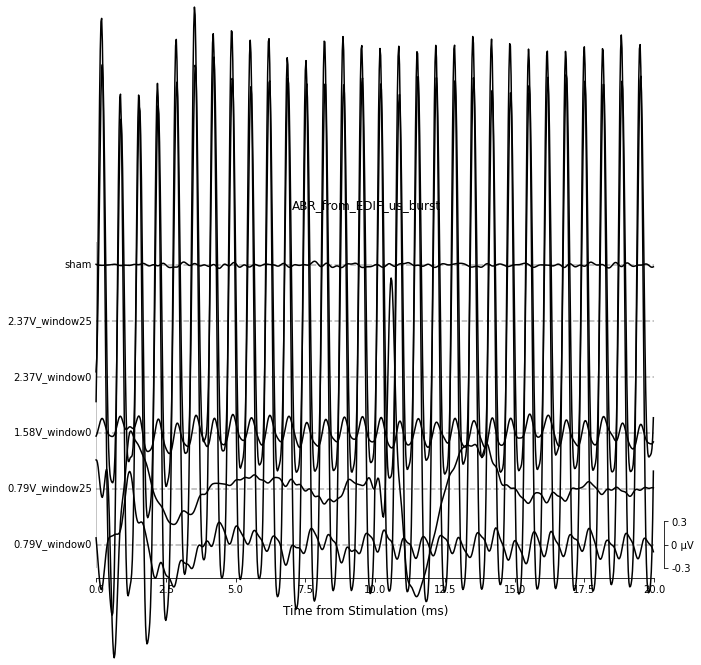

In [19]:
#各ファイルに対してLFPの描画・CSDの描画・ABRの描画を行う
abr_dic={}
dir_name=plx_filelist[0].parent
#赤コネクタ
#channelmap=[8,9,7,10,4,13,5,12,2,15,1,16,3,14,6,11]
#白コネクタ
channelmap=[9,8,10,7,13,4,12,5,15,2,16,1,14,3,11,6]
lfp_ylim=[-300,300]
abr_ylim=[-0.3,0.3]
csd_vrange=50
is_diff=False
for plx_filepath in plx_filelist:
    print(plx_filepath.name)
    lfp_data=process_lfp(plx_filepath,50,350)
    if "click" in plx_filepath.name:
        dB=re.search("click_(\d+)",plx_filepath.name).group(1)
        # info=re.search("click_(\d+)_(.*).mat",plx_filepath.name).group(2)
        # print(dB,info)
        # param=f"click_{dB}dB_{info}"
        # abr_dic[info]=process_abr(plx_filepath,[0,20],is_diff)
        param=f"click_{dB}dB"
        abr_dic[f"{dB}dB"]=process_abr(plx_filepath,[0,20],is_diff)
    elif "us_burst" in plx_filepath.name:
        try:
            vol = re.search("us_burst_(.*)_window_(.*).mat",plx_filepath.name).group(1)
            window = re.search("us_burst_(.*)_window_(.*).mat",plx_filepath.name).group(2)
            param = f"us_burst_{vol}_window_{window}%"
            abr_dic[f"{vol}_window{window}"]=process_abr(plx_filepath,[0,20],is_diff)
            # abr_dic[f"{vol}_window{window}"]=notchpass(abr_dic[f"{vol}_window{window}"],[1400,1600],40000)
            # abr_dic[f"{vol}_window{window}"]=notchpass(abr_dic[f"{vol}_window{window}"],[2900,3100],40000)
        except:
            abr_dic["sham"]=process_abr(plx_filepath,[0,20],is_diff)
            param="sham"
    elif "us_cont" in plx_filepath.name:
        vol = re.search("us_cont_(.*)_window_(.*).mat",plx_filepath.name).group(1)
        window = re.search("us_cont_(.*)_window_(.*).mat",plx_filepath.name).group(2)
        param = f"us_cont_{vol}_window_{window}"
        abr_dic[f"{vol}\nwindow{window}"]=process_abr(plx_filepath,[0,20],is_diff)
    plot_lfp(lfp_data,channelmap,lfp_ylim,param)
    plot_csd(lfp_data,channelmap,[-50,350],csd_vrange,param)
#plot_fourier_spectal_from_dic(abr_dic,dir_name)
if "click" in plx_filelist[-1].name:
    title= "ABR_from_EDIF_click"
elif "us_burst" in plx_filelist[-1].name:
    title= "ABR_from_EDIF_us_burst"
    #abr_dic=notch_filtered_dict(abr_dic,[1400,1600],40000)
    #abr_dic=notch_filtered_dict(abr_dic,[2900,3100],40000)
elif "us_cont" in plx_filelist[-1].name:
    title= "ABR_from_EDIF_us_cont"
plot_abr(abr_dic,title,dir_name.name,abr_ylim)



click_60.mat
us_burst_158V_window_0.mat
us_cont_158V_window_0ms.mat


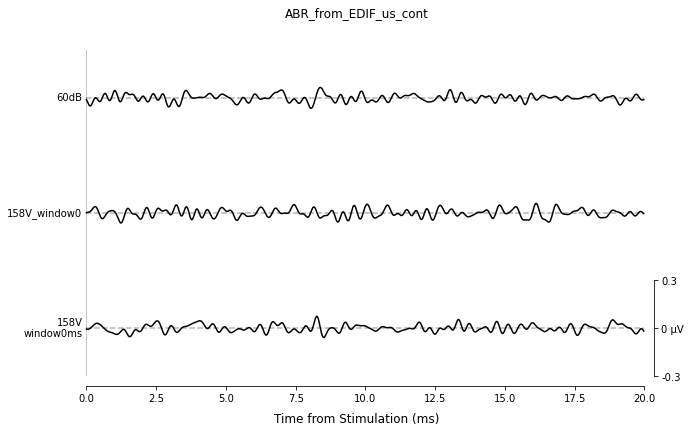

In [36]:
#ABRだけ
abr_dic={}
dir_name=plx_filelist[0].parent
#赤コネクタ
#channelmap=[8,9,7,10,4,13,5,12,2,15,1,16,3,14,6,11]
#白コネクタ
channelmap=[9,8,10,7,13,4,12,5,15,2,16,1,14,3,11,6]
lfp_ylim=[-300,300]
abr_ylim=[-0.3,0.3]
csd_vrange=50
is_diff=False
fourier_xlim=[200,4000]
for plx_filepath in plx_filelist:
    print(plx_filepath.name)
    #lfp_data=process_lfp(plx_filepath,50,350)
    if "click" in plx_filepath.name:
        dB=re.search("click_(\d+)",plx_filepath.name).group(1)
        # info=re.search("click_(\d+)_(.*).mat",plx_filepath.name).group(2)
        # print(dB,info)
        # param=f"click_{dB}dB_{info}"
        # abr_dic[info]=process_abr(plx_filepath,[0,20],is_diff)
        param=f"click_{dB}dB"
        abr_dic[f"{dB}dB"]=process_abr(plx_filepath,[0,20],is_diff)
    elif "us_burst" in plx_filepath.name:
        try:
            vol = re.search("us_burst_(.*)_window_(.*).mat",plx_filepath.name).group(1)
            window = re.search("us_burst_(.*)_window_(.*).mat",plx_filepath.name).group(2)
            param = f"us_burst_{vol}_window_{window}%"
            abr_dic[f"{vol}_window{window}"]=process_abr(plx_filepath,[0,20],is_diff)
            # abr_dic[f"{vol}_window{window}"]=notchpass(abr_dic[f"{vol}_window{window}"],[1400,1600],40000)
            # abr_dic[f"{vol}_window{window}"]=notchpass(abr_dic[f"{vol}_window{window}"],[2900,3100],40000)
        except:
            abr_dic["sham"]=process_abr(plx_filepath,[0,20],is_diff)
            param="sham"
    elif "us_cont" in plx_filepath.name:
        vol = re.search("us_cont_(.*)_window_(.*).mat",plx_filepath.name).group(1)
        window = re.search("us_cont_(.*)_window_(.*).mat",plx_filepath.name).group(2)
        param = f"us_cont_{vol}_window_{window}"
        abr_dic[f"{vol}\nwindow{window}"]=process_abr(plx_filepath,[0,20],is_diff)
    #plot_lfp(lfp_data,channelmap,ylim,param)
    #plot_csd(lfp_data,channelmap,[-50,350],param)
plot_fourier_spectal_from_dic(abr_dic,dir_name,fourier_xlim,40000)
if "click" in plx_filelist[-1].name:
    if is_diff:
        title= "ABR_from_EDIF_click_from_18-19"
    else:
        title="ABR_from_EDIF_click_from_17"
elif "us_burst" in plx_filelist[-1].name:
    title= "ABR_from_EDIF_us_burst_filtered"
    # abr_dic=notch_filtered_dict(abr_dic,[1400,1600],40000)
    # abr_dic=notch_filtered_dict(abr_dic,[2900,3100],40000)
elif "us_cont" in plx_filelist[-1].name:
    title= "ABR_from_EDIF_us_cont"
plot_abr(abr_dic,title,dir_name.name,abr_ylim)
#abr_dicの保存
if not os.path.exists("./json"):
    os.mkdir("./json")
with open(f'./json/{dir_name}_abr.json', 'w') as f:
    json.dump(abr_dic, f, indent=2,cls=MyEncoder)

In [24]:
#TDTのデータを元に波形を描画
dir_path=Path("../TDT")
csv_files=list(dir_path.glob("*"))
csv_files

[WindowsPath('../TDT/after_dura.csv'), WindowsPath('../TDT/before_skin.csv')]

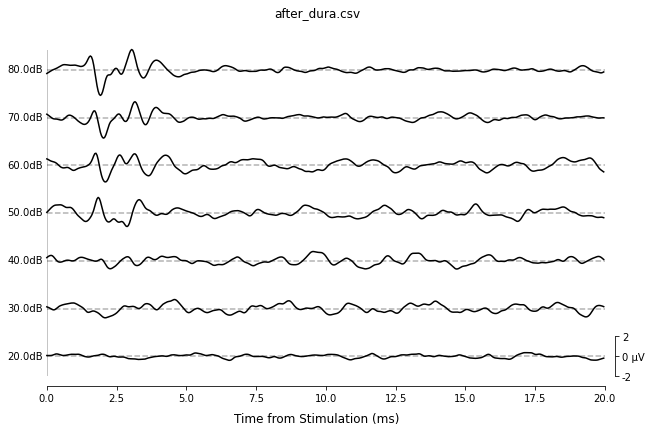

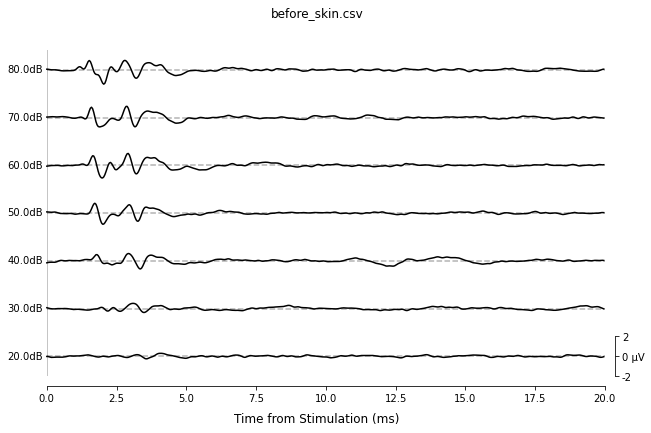

In [25]:
dir_name=dir_path.name
abr_ylim=[-2,2]
for csv_file in csv_files:
    abr_dic=read_tdtcsv(csv_file)
    title=csv_file.name[:-4]
    plot_fourier_spectal_from_dic(abr_dic,f"TDT_{title}",fourier_xlim,40000)
    plot_abr(abr_dic,title,dir_name,abr_ylim)